# Getting derivatives of a noisy non-analytic function
Using this notebook to qualitativly compare several filtering schemes.

## Importing the raw data from csv

One thing is that we need to know the cutoff indices of the useful frames of each sequence.

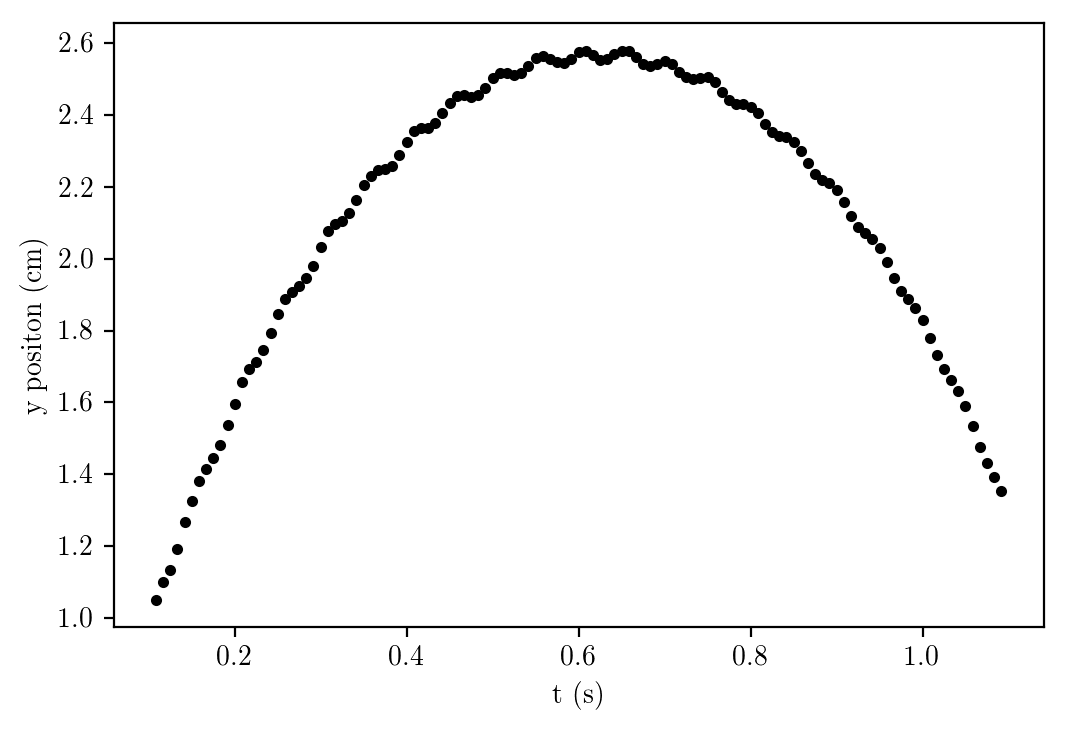

In [1]:
import csv
import numpy as np

y = []
t = []
f = open('../data/filter_test_data.csv')
droplet_position_data = csv.reader(f, delimiter=',')
next(droplet_position_data)
for row in droplet_position_data:
    y.append(row[0])
    t.append(row[1])

y = np.array(y).astype(float)
t = np.array(t).astype(float)/120.
dt= float(t[1]-t[0])

# plot with matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#from pylab import *
#from matplotlib2tikz import save as tikz_save

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(t,y, 'k.')
plt.xlabel('t (s)')
plt.ylabel('y positon (cm)')
plt.show();

In [2]:
def savefig(filename):
    plt.savefig('../doc/figures/{}.pgf'.format(filename), bbox_inches='tight')
plt.rcParams['figure.dpi'] = 300

## Convolution with the derivative of a gaussian kernel

In [3]:
from scipy import ndimage

#Normalization:
dt = t[1] - t[0] # use np.diff(x) if x is not uniform
dtdt = dt**2

#First derivatives:
dy = np.diff(y) / dt
cy = np.convolve(y, [1,-1]) / dt
gy = ndimage.gaussian_filter1d(y, sigma=1, order=1, mode='wrap') / dt

#Second derivatives:
ddy = np.diff(y, 2) / dtdt
ccy = np.convolve(y, [1, -2, 1]) / dtdt
ggy = ndimage.gaussian_filter1d(y, sigma=1, order=2, mode='wrap') / dtdt

## Wiener Filtering

In [4]:
from scipy import signal
wiener_y = signal.wiener(y, mysize=20, noise=0.05)
wiener_y2 = signal.wiener(wiener_y, mysize=10, noise=0.05)
wiener_y3 = signal.wiener(wiener_y2, mysize=6, noise=0.005)
wiener_y4 = signal.wiener(wiener_y3, mysize=4, noise=0.005)
wiener_y5 = signal.wiener(wiener_y4, mysize=2, noise=0.005)

In [5]:
n = 0
dy2 = signal.wiener(np.diff(wiener_y5[n:]), mysize=3, noise=0.05 ) / dt
ddy2 = signal.wiener(np.diff(wiener_y5[n:],2), mysize=80, noise=0.005) / dtdt

How do I pick the 'mysize' parameter?

## Spline fits

In [6]:
from scipy.interpolate import UnivariateSpline
npts = len(t)
k = 5 # 5th degree spline
s = npts - np.sqrt(2*npts) # smoothing factor
#print(s)

spline_0 = UnivariateSpline(t, wiener_y5, k=k, s=.2)
spline_1 = UnivariateSpline(t, wiener_y5, k=k, s=.2).derivative(n=1)
spline_2 = UnivariateSpline(t, wiener_y5, k=k, s=.2).derivative(n=2)

## FFT

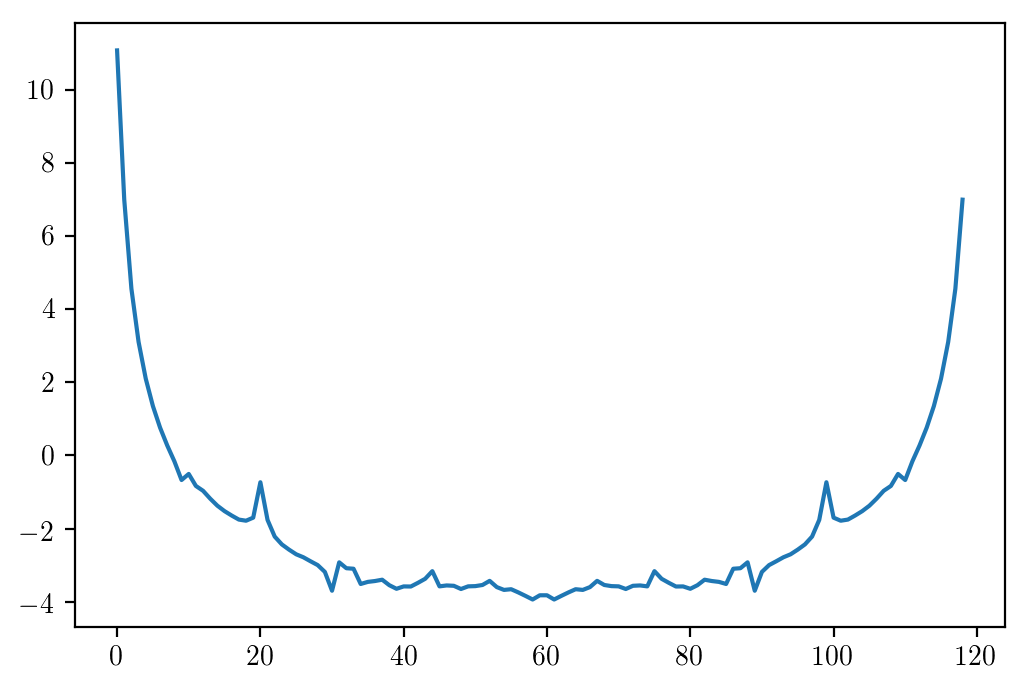

In [7]:
from scipy.fftpack import fft

f = fft(y)
p = np.log(np.real(f * np.conj(f)))

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(p)
plt.show();

Data is non-periodic...

## Savitzky-Golay Filtering

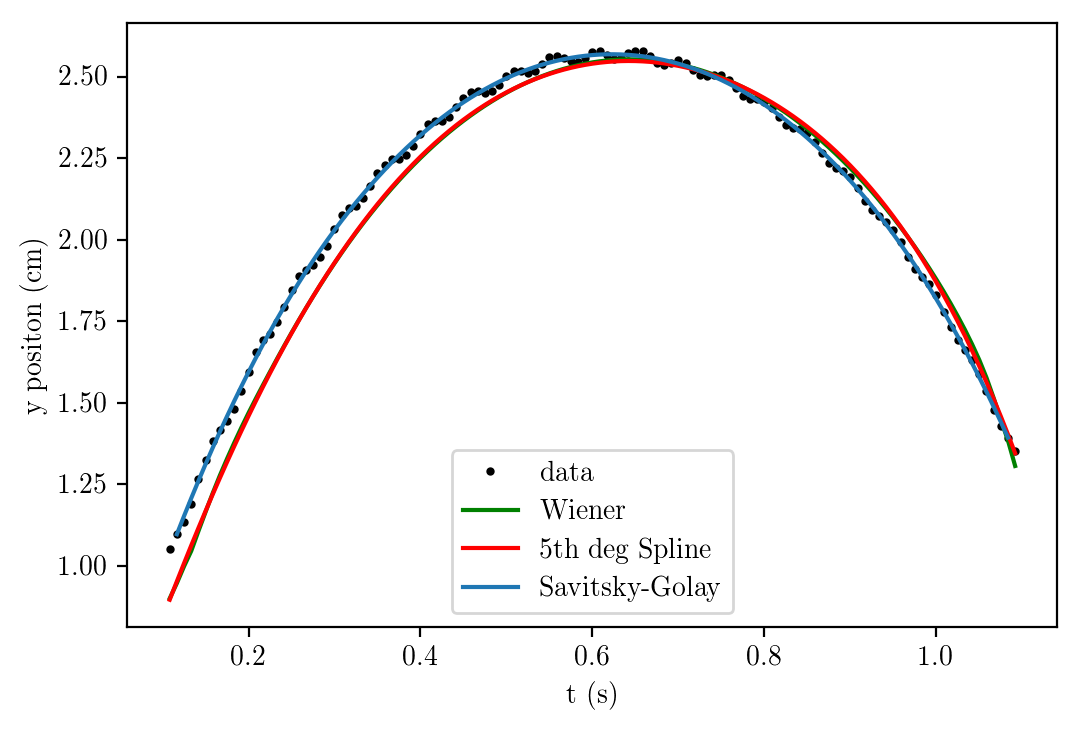

In [8]:
#yt = np.column_stack((y,t))
y_savgol = signal.savgol_filter(y, 25, 3, deriv=0, axis=0)
y_savgol1 = signal.savgol_filter(y_savgol, 25, 3, deriv=0, axis=0)
y_savgol2 = signal.savgol_filter(y_savgol1, 25, 3, deriv=0, axis=0)
y_savgol3 = signal.savgol_filter(y_savgol2, 25, 3, deriv=0, axis=0)
dy_savgol = signal.savgol_filter(y_savgol3, 25, 3, deriv=1, axis=0)/dt
ddy_savgol = signal.savgol_filter(y_savgol3, 25, 3, deriv=2, axis=0)/dtdt

plt.figure(figsize=(6, 4), dpi=100)
plt.xlabel('t (s)')
plt.ylabel('y positon (cm)')
plt.plot(t, y, 'ko', ms=2, label='data')
plt.plot(t, wiener_y5, 'g', ms=2, label='Wiener')
plt.plot(t, spline_0(t), 'r', label='5th deg Spline')
plt.plot(t[1:-1],y_savgol3[1:-1], label='Savitsky-Golay')
plt.legend(loc='best')
plt.show();

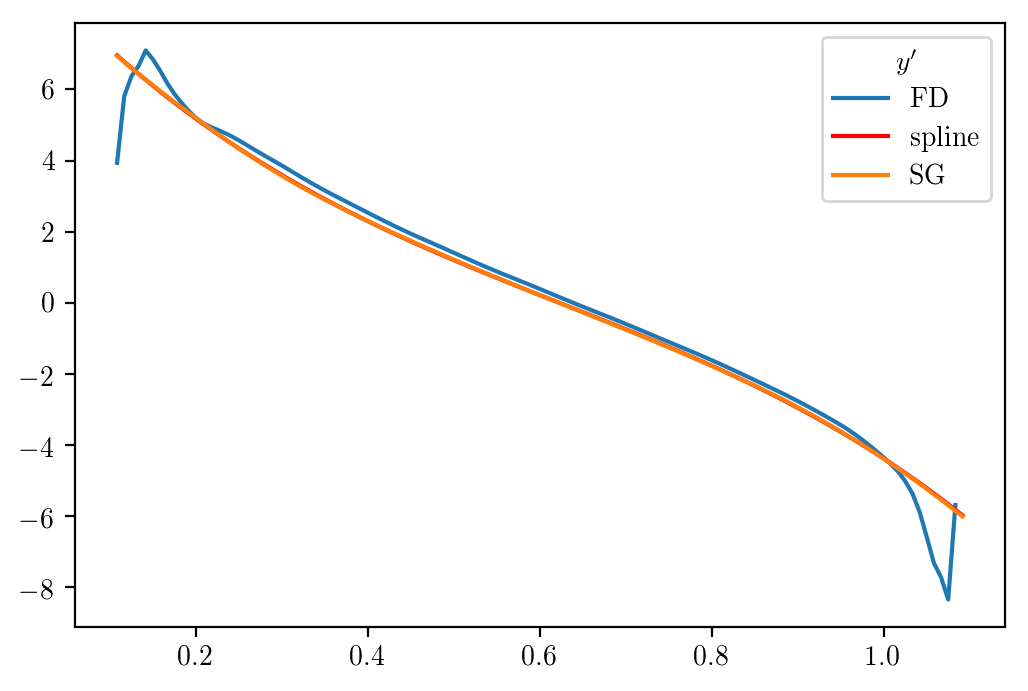

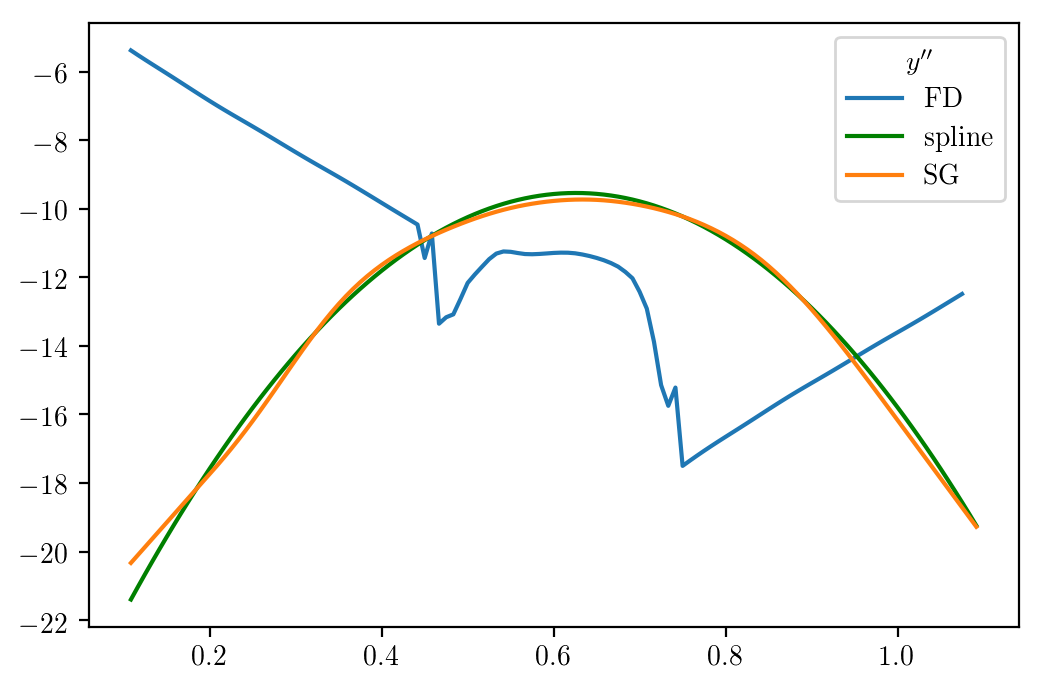

In [9]:
spline_0 = UnivariateSpline(t, y_savgol3, k=k, s=s)
spline_1 = UnivariateSpline(t, y_savgol3, k=k, s=s).derivative(n=1)
spline_2 = UnivariateSpline(t, y_savgol3, k=k, s=s).derivative(n=2)

# plot data, spline fit, and derivatives
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(t[:-1],dy2, label='FD')
plt.plot(t, spline_1(t), 'r', label='spline')
plt.plot(t,dy_savgol, label='SG')
plt.legend(title = r"$y'$")
plt.show();

plt.figure(figsize=(6, 4), dpi=100)
plt.plot(t[:-2],ddy2, label='FD')
plt.plot(t, spline_2(t), 'g', label='spline')
plt.plot(t,ddy_savgol, label='SG')
plt.legend(title = r"$y''$")
plt.show();

## Big grab bag of methods

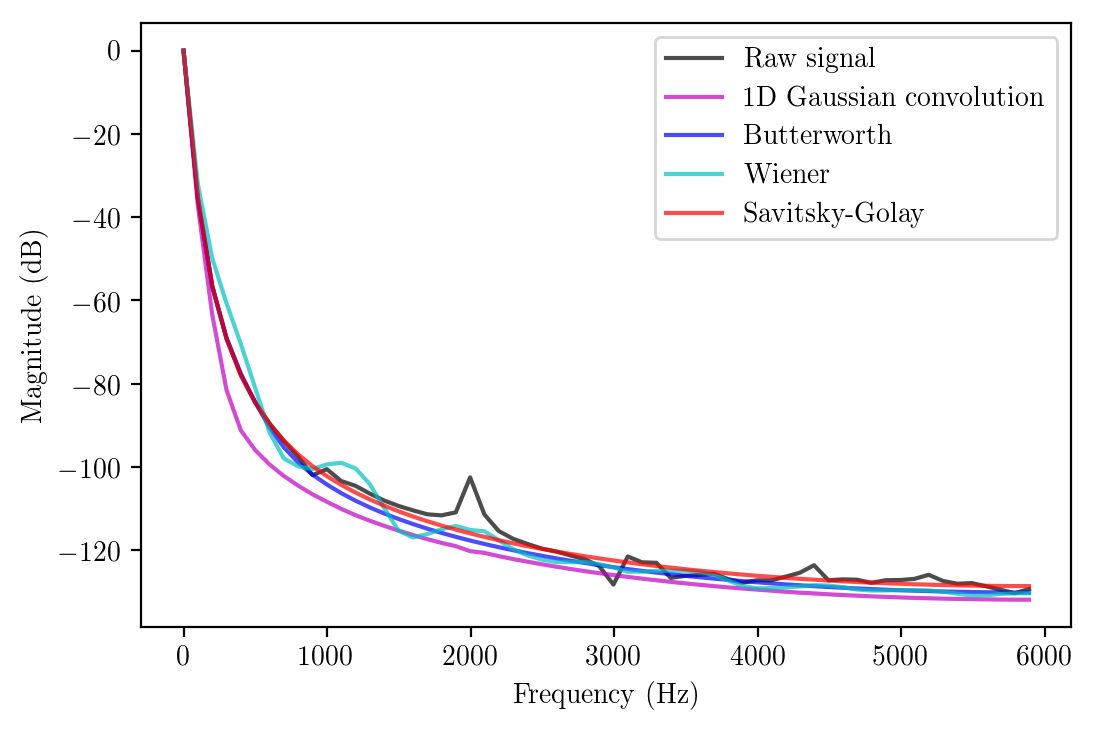

In [10]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
#import scipy.optimize as op

#def ssqe(sm, s, npts):
 #   return np.sqrt(np.sum(np.power(s-sm,2)))/npts

def testGauss(x, y, npts):
    b = gaussian(39, 10)
    #ga = filtfilt(b/b.sum(), [1.0], y)
    ga = filters.convolve1d(y, b/b.sum())
    plt.plot(x, ga)
    #print("gaerr", ssqe(ga, s, npts))
    return ga

def testButterworth(nyf, x, y, npts):
    #c = 5/len(x) #0.05
    c = 5
    b, a = butter(4, c/nyf)
    fl = filtfilt(b, a, y)
    plt.plot(x,fl)
    #print("flerr", ssqe(fl, s, npts))
    return fl

def testWiener(x, y, npts):
    wi = wiener(y, mysize=29, noise=0.5)
    plt.plot(x,wi)
    #print "wieerr", ssqe(wi, s, npts)
    return wi

def testSpline(x, y, npts):
    #s = npts * (rmserror * np.fabs(y).max())**2
    sp = UnivariateSpline(x, y, k=5, s=20*2)
    dsp = UnivariateSpline(x, y, k=5, s=20*2).derivative(n=1)
    ddsp = UnivariateSpline(x, y, k=5, s=20*2).derivative(n=2)
    #plt.plot(x,sp(x))
    #print "splerr", ssqe(sp(x), s, npts)
    return sp(x), dsp(x), ddsp(x)

def testSG(x, y, npts):
    y_savgol = signal.savgol_filter(y, 25, 3, deriv=0, axis=0)
    y_savgol1 = signal.savgol_filter(y_savgol, 25, 3, deriv=0, axis=0)
    y_savgol2 = signal.savgol_filter(y_savgol1, 25, 3, deriv=0, axis=0)
    sg = signal.savgol_filter(y_savgol2, 25, 3, deriv=0, axis=0)
    dsg = signal.savgol_filter(sg, 25, 3, deriv=1, axis=0)/dt
    plt.plot(x, sg)
    return sg, dsg

def plotPowerSpectrum(y, w):
    ft = np.fft.rfft(y)
    ps = np.real(ft*np.conj(ft))*np.square(dt)
    #plt.plot(w, ps)
    return decibel(ps)

def decibel(lin):
    """Convert amplitude to decibel.  We might later need power to decibel..."""
    return 20*np.log10(norm(lin))

def norm(sig):
    """Normalisze signal."""
    sig_max = np.float(np.max(np.abs(sig)))
    return sig / sig_max
    
npts = len(t)
end = t[-1]
dt = end/float(npts)
nyf = 0.5/dt
sigma = 0.5 
#r = np.random.normal(scale = sigma, size=(npts))
#s = np.sin(2*np.pi*x)#+np.sin(4*2*np.pi*x)
#y = s + r
# plt.plot(x,s)
# plt.plot(x,y,ls='none',marker='.')
ga = testGauss(t, y, npts)
fl = testButterworth(nyf, t, y, npts)
wi = testWiener(t, y, npts)
sp = testSpline(t, y, npts)[0]
dsp = testSpline(t, y, npts)[1]
ddsp = testSpline(t, y, npts)[2]
sg, dsg = testSG(t,y, npts)
plt.legend(['meas','gauss','iir','wie','spl'], loc='upper center')
plt.clf()
w = np.fft.fftfreq(npts, d=dt)
w = np.abs(w[:int(npts/2)+1]) #only freqs for real fft

plt.figure(figsize=(6, 4), dpi=100)
#plotPowerSpectrum(s, w)

plt.plot(w/dt, plotPowerSpectrum(y, w), 'k', alpha=0.7)
plt.plot(w/dt, plotPowerSpectrum(ga, w), 'm', alpha=0.7)
plt.plot(w/dt, plotPowerSpectrum(fl, w), 'b', alpha=0.7)
plt.plot(w/dt, plotPowerSpectrum(wi, w), 'c', alpha=0.7)
plt.plot(w/dt, plotPowerSpectrum(sg, w), 'r', alpha=0.7)
#plt.yscale('log')
#plt.xscale('log')

#plt.xlim([0,10])
#plt.ylim([1E-8,None])
plt.legend(['Raw signal','1D Gaussian convolution','Butterworth','Wiener','Savitsky-Golay'], loc='best')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')

#tikz_save('../doc/figures/power_spectra.tex',
#           figureheight = '\\figureheight',
#           figurewidth = '\\figurewidth')

savefig('power_spectra')
plt.show();

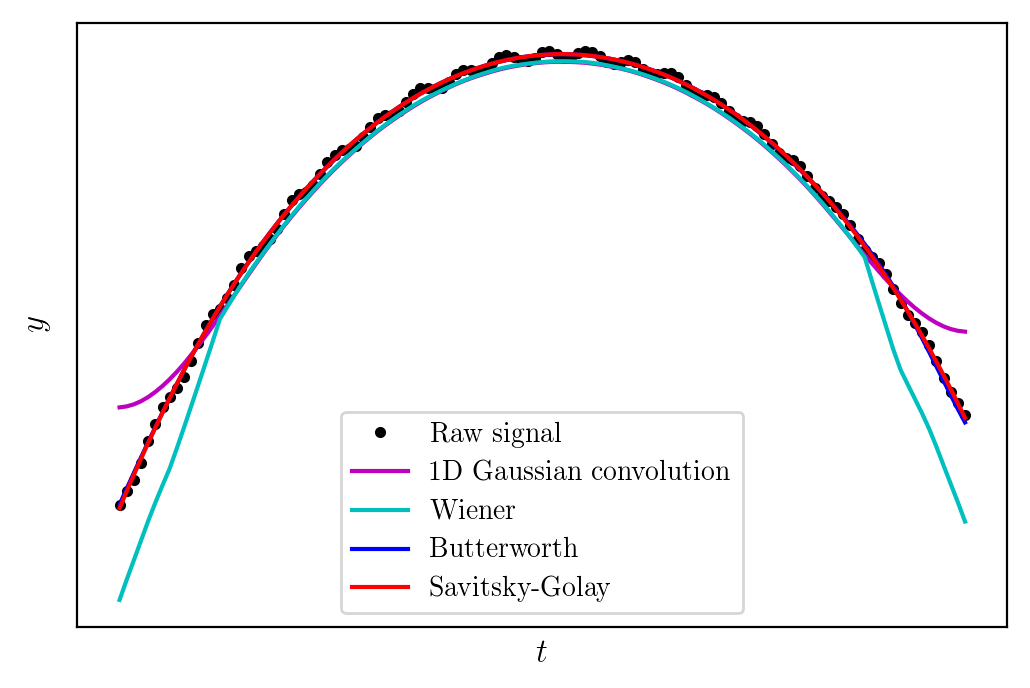

In [11]:
fig,ax = plt.subplots(1, figsize=(6, 4), dpi=100)
ax.plot(t, y, 'k.', label='Raw signal')
ax.plot(t, ga, 'm', label='1D Gaussian convolution')
ax.plot(t, wi, 'c', label='Wiener')
ax.plot(t,fl, 'b', label='Butterworth')
ax.plot(t, sg, 'r', label='Savitsky-Golay')
ax.legend(loc='best')
ax.set_ylabel(r"$y$", fontsize=12, labelpad=10)
ax.set_xlabel('$t$', fontsize=12)
plt.xticks([])
plt.yticks([])

#tikz_save('../doc/figures/y_filtered.tex',
#           figureheight = '\\figureheight',
#           figurewidth = '\\figurewidth')

savefig('y_filtered')
plt.show();

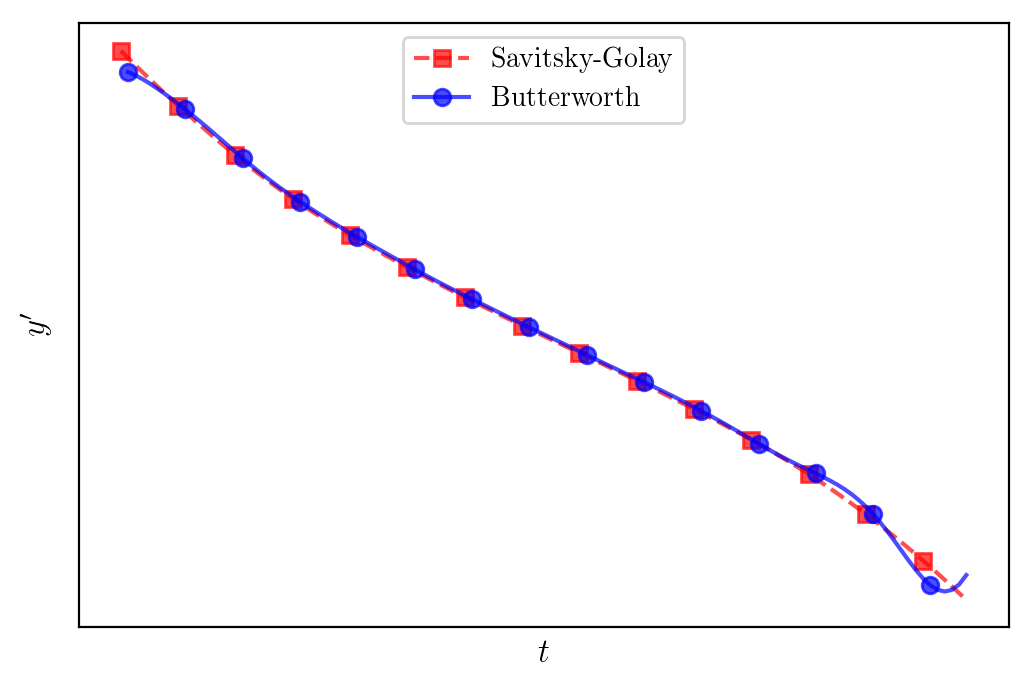

In [12]:
mk = 8
fig,ax = plt.subplots(1, figsize=(6, 4), dpi=100)
#plt.figure(figsize=(6, 4), dpi=100)
#plt.plot(t, y, 'k.', label='raw')
#plt.plot(t, ga, label='1D Gaussian convolution')
#plt.plot(t, wi, label='Wiener')
ax.plot(t, dsg, 'rs--', label='Savitsky-Golay', markevery=mk, alpha=0.7)
ax.plot(t[1:],np.diff(fl)/dt, 'bo-', label='Butterworth', markevery=mk, alpha=0.7)
ax.legend(loc=9)
ax.set_ylabel(r"$y'$", fontsize=12, labelpad=10)
ax.set_xlabel('$t$', fontsize=12)
plt.xticks([])
plt.yticks([])

#tikz_save('../doc/figures/dy_filtered.tex',
#           figureheight = '\\figureheight',
#           figurewidth = '\\figurewidth')

savefig('dy_filtered')
plt.show()

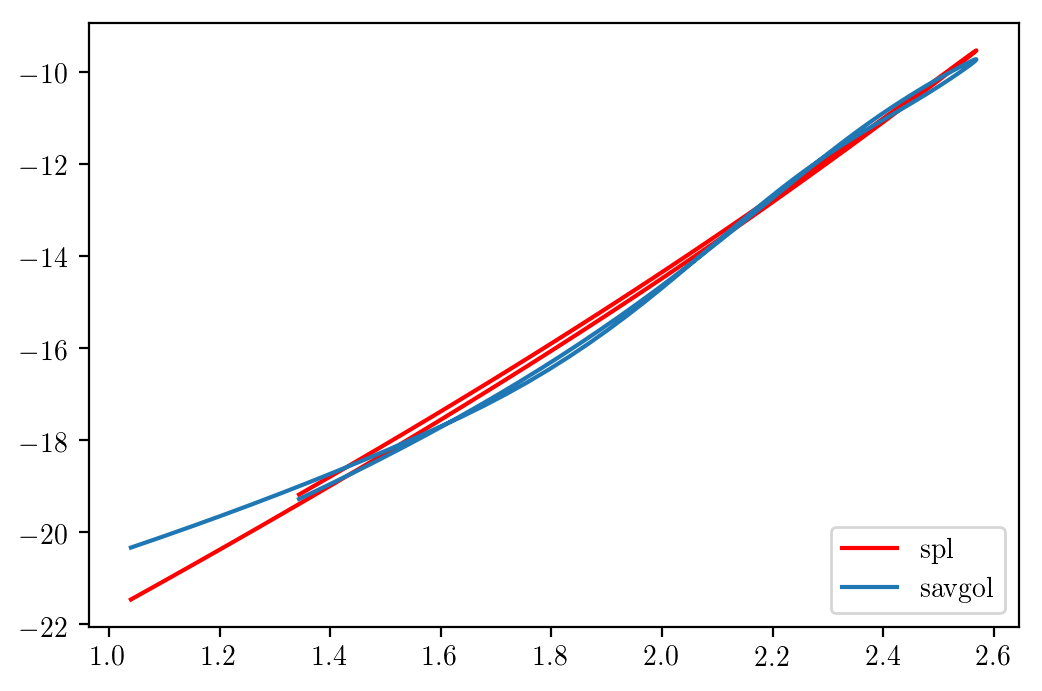

In [13]:
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(y_savgol3, ddsp, 'r')
plt.plot(y_savgol3,ddy_savgol)
plt.legend(['spl','savgol'], loc='lower right')
plt.show();

## Charge decay

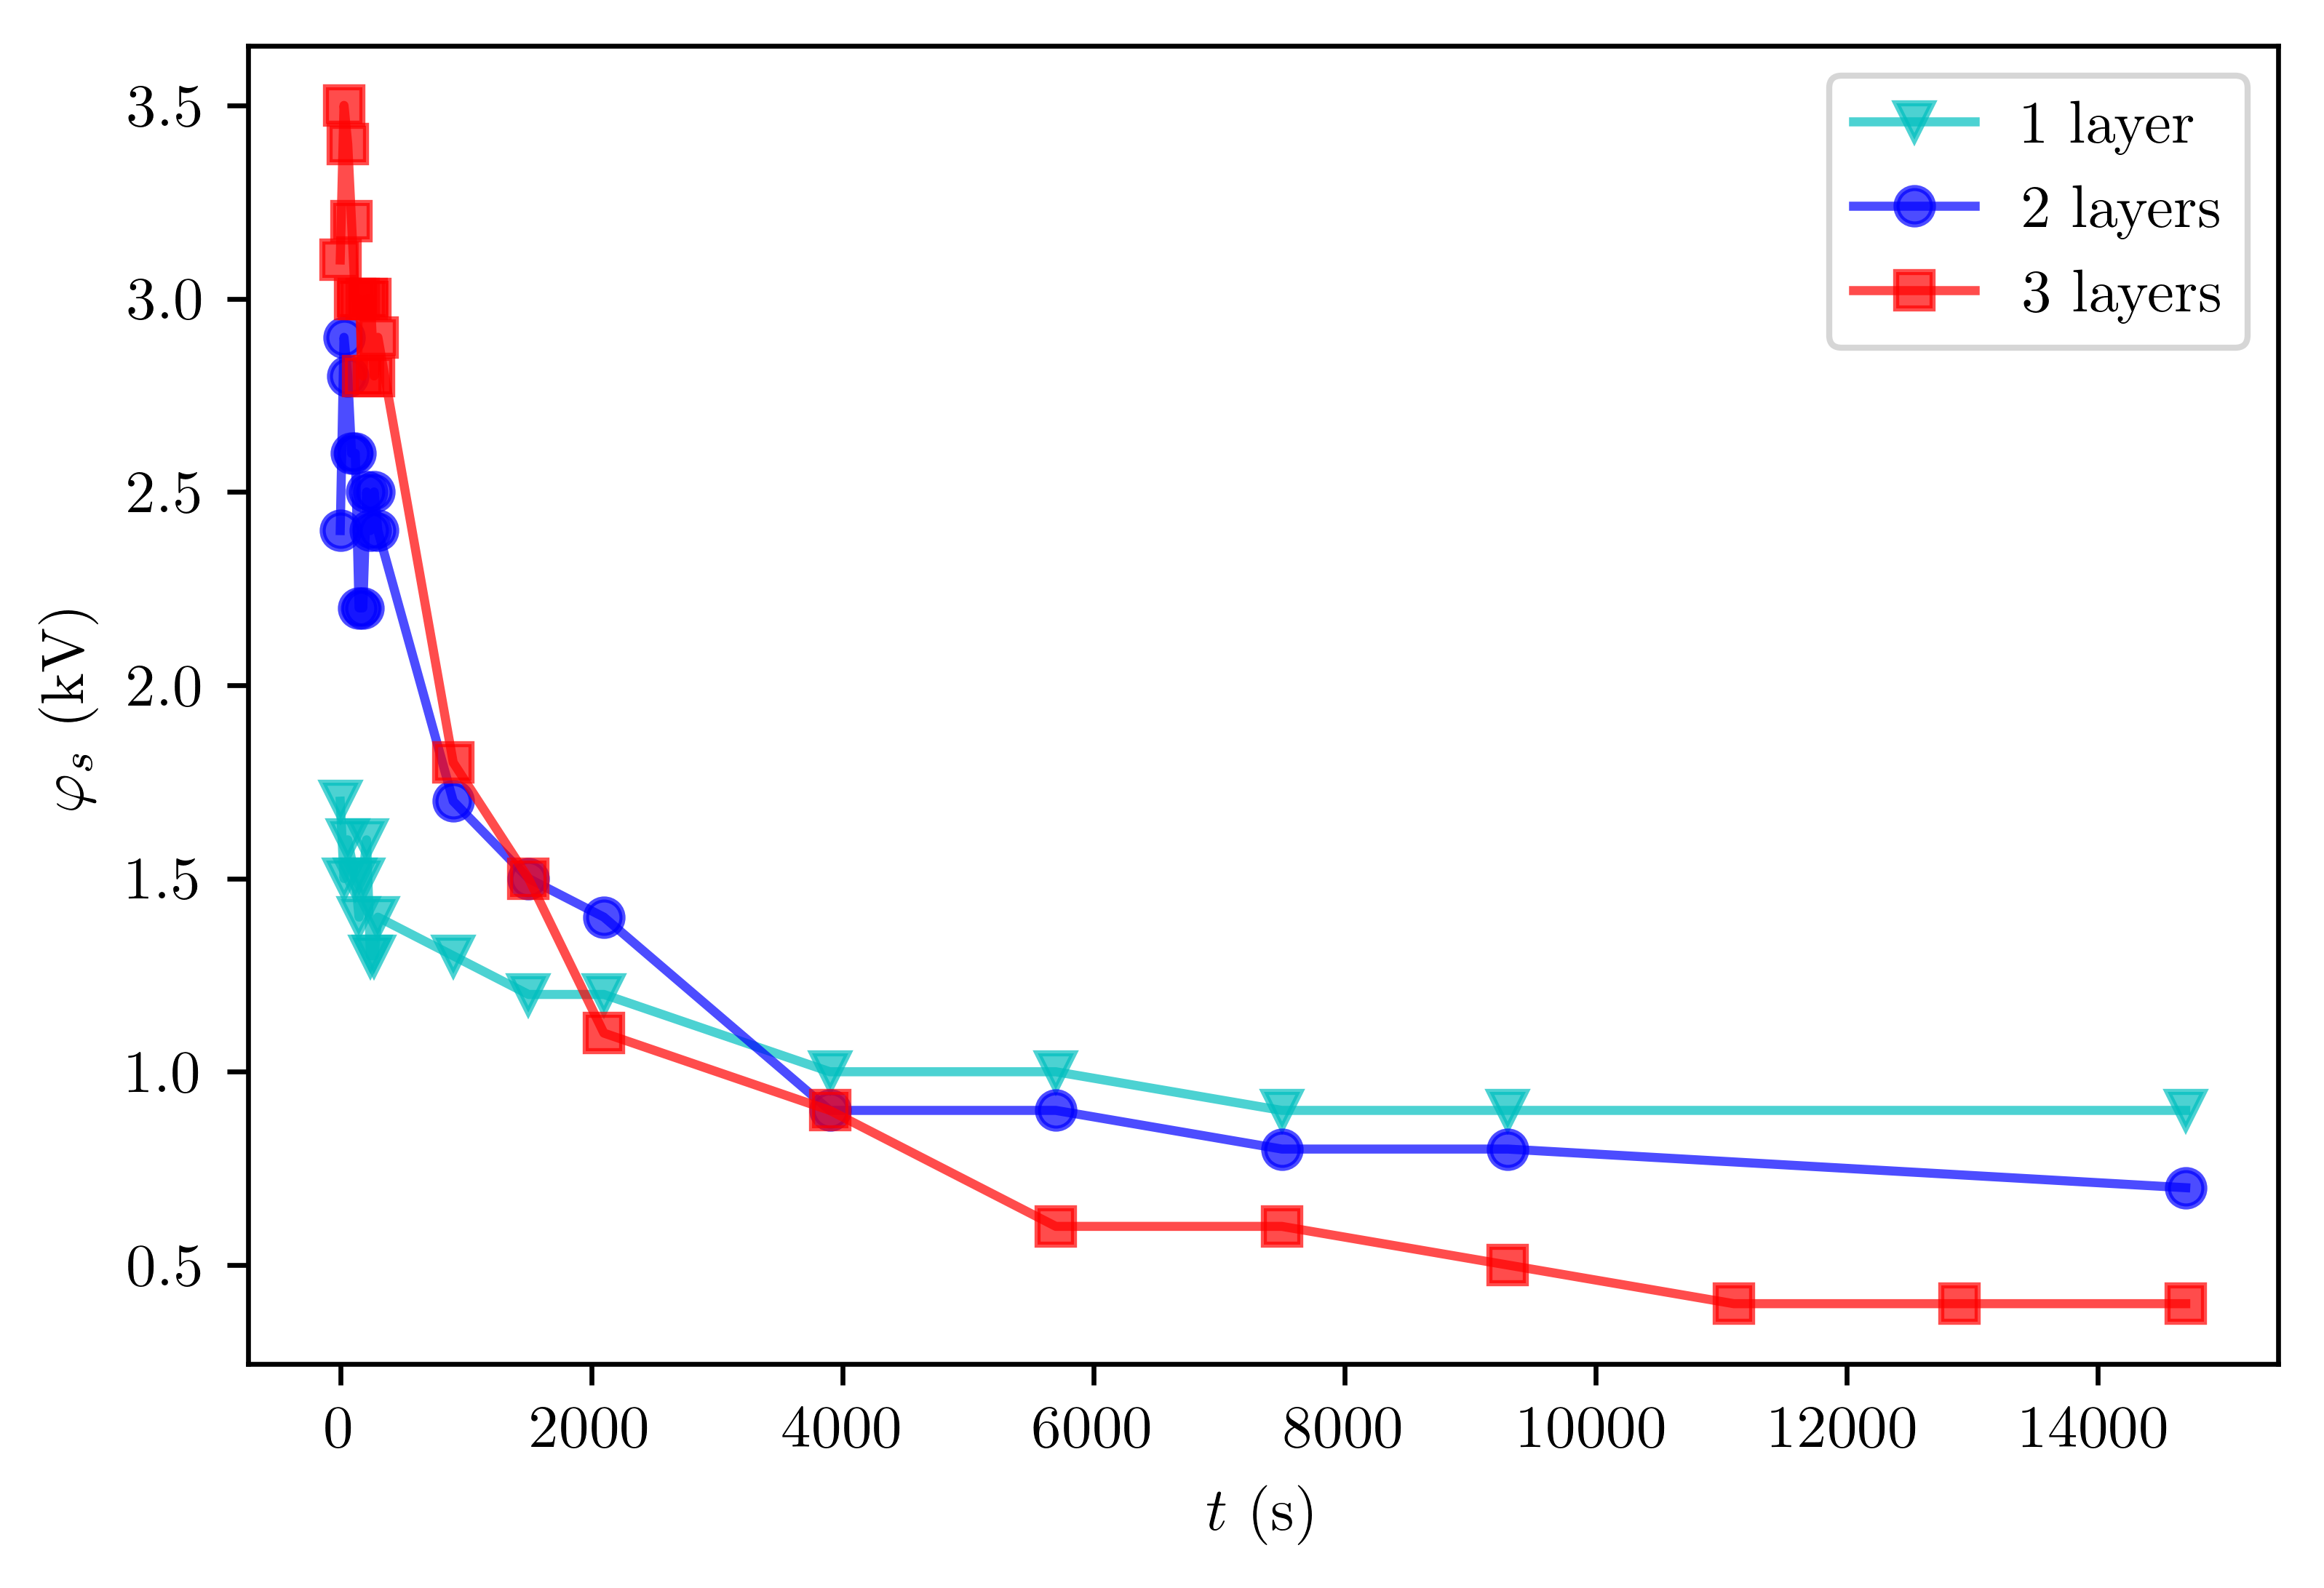

In [14]:
import csv
import numpy as np

#y1 = []
#y2 = []
#y3 = []
#t = []
#f = open('../data/charge_decay.csv')
#charge_decay_data = csv.reader(f, delimiter=',')
#next(charge_decay_data)
#for row in charge_decay_data:
#    t.append(row[0])
#    y1.append(row[1])
#    y2.append(row[2])
#    y3.append(row[3])
#
#y1 = np.array(y1).astype(float)
#y2 = np.array(y2).astype(float)
#y3 = np.array(y3).astype(float)
#t = np.array(t).astype(float)

c = '../data/charge_decay.csv'
t, l3, l2, l1 = np.genfromtxt(c, delimiter=',', unpack=True)
l1mask = np.isfinite(l1)
l2mask = np.isfinite(l2)
l3mask = np.isfinite(l3)

# plot with matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#from pylab import *
#from matplotlib2tikz import save as tikz_save

plt.figure(figsize=(6, 4))#, dpi=100)
plt.plot(t[l1mask], l1[l1mask], 'cv-', label='1 layer', alpha=0.7)
plt.plot(t[l2mask], l2[l2mask], 'bo-', label='2 layers', alpha=0.7)
plt.plot(t[l3mask], l3[l3mask], 'rs-', label='3 layers', alpha=0.7)
plt.xlabel('$t$ (s)')
plt.ylabel(r'$\varphi_s$ (kV)')
plt.legend()

savefig('charge_decay')
plt.show();